In [1]:
import sys
!{sys.executable} -m pip install shap


   ---------------------------------------- 0.0/547.0 kB ? eta -:--:--
   ---------------------------------------- 547.0/547.0 kB 9.2 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 26.4 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   --------- ------------------------------ 9.2/38.1 MB 47.7 MB/s eta 0:00:01
   ------------------- -------------------- 18.4/38.1 MB 44.6 MB/s eta 0:00:01
   ---------------------------- ----------- 26.7/38.1 MB 43.5 MB/s eta 0:00:01
   ---------------------------------- ----- 33.3/38.1 MB 41.5 MB/s eta 0:00:01
   ---------------------------------------  37.2/38.1 MB 38.2 MB/s eta 0:00:01
   ---------------------------------------  38.0/38.1 MB 35.5 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 30.7 MB/s  0:00:01

   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("new_flight_weather_merged.csv")

df["departure_datetime"] = pd.to_datetime(df["departure_datetime"])
df["dep_hour"] = df["departure_datetime"].dt.hour
df["dep_weekday"] = df["departure_datetime"].dt.weekday
df["is_weekend"] = df["dep_weekday"].isin([5, 6]).astype(int)

num_cols = ["기온(°C)", "풍속_ms", "dep_hour", "dep_weekday", "is_weekend"]
cat_cols = ["공항명", "출발지", "도착지", "flight_type"]

for c in cat_cols:
    df[c] = df[c].astype("category")

X_cols = num_cols + cat_cols


C:\Users\Admin\AppData\Local\Temp\ipykernel_13440\472009205.py:1: DtypeWarning: Columns (28,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("new_flight_weather_merged.csv")


In [4]:
df = df.sort_values("departure_datetime")
split_date = df["departure_datetime"].quantile(0.8)

train_df = df[df["departure_datetime"] <= split_date]
test_df  = df[df["departure_datetime"] > split_date]

X_test = test_df[X_cols]
y_test = test_df["is_delay"]


In [5]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    objective="binary",
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    train_df[X_cols],
    train_df["is_delay"],
    categorical_feature=cat_cols
)


[LightGBM] [Info] Number of positive: 336343, number of negative: 1938804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 2275147, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=500, n_jobs=-1, num_leaves=64,
               objective='binary', random_state=42, subsample=0.8)

In [6]:
fi = pd.DataFrame({
    "feature": lgbm.feature_name_,
    "importance": lgbm.booster_.feature_importance(importance_type="gain")
}).sort_values("importance", ascending=False)

fi.head(15)


,feature,importance
7,도착지,1.994501e+06
2,dep_hour,1.851553e+06
5,공항명,5.969707e+05
0,기온(°C),4.178022e+05
1,풍속_ms,2.014121e+05
6,출발지,1.667050e+05
3,dep_weekday,9.962136e+04
8,flight_type,6.903900e+04
4,is_weekend,6.679198e+03


In [7]:
explainer = shap.TreeExplainer(lgbm)

X_sample = X_test.sample(n=5000, random_state=42)
shap_values = explainer.shap_values(X_sample)


C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 한글 폰트 지정
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False


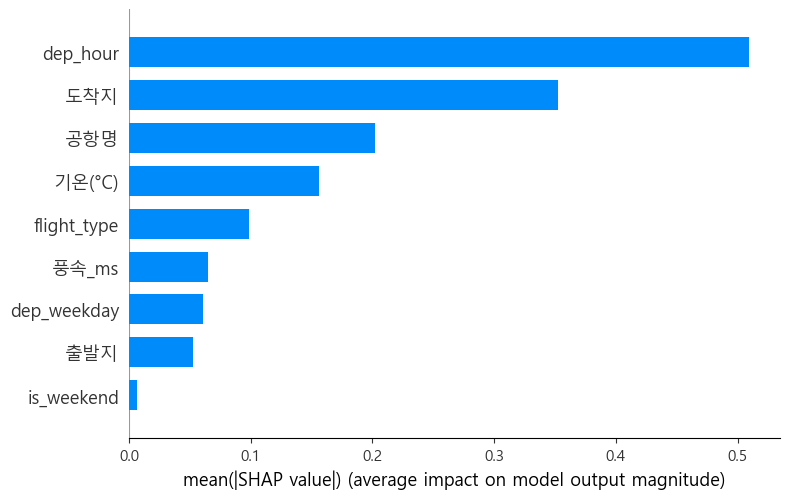

In [11]:
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=10)


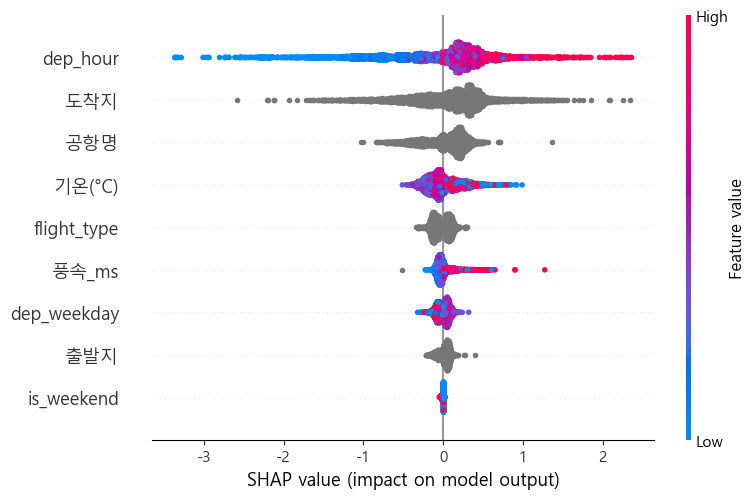

In [12]:
shap.summary_plot(shap_values, X_sample, max_display=10)
